In [1]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [206]:
# Imports
from aoc23.utils import read_input
from itertools import pairwise
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
input_23 = read_input(23)

## Part 1

In part 1 of the [day 23 puzzle](https://adventofcode.com/2023/day/23), we are given a representation of a maze, through which we are asked to find a path from the entrance (in the top left corner) to the exit (in the bottom right corner). The maze representation consists of the following characters:
- `#` = maze walls,
- `.` = maze paths,
- `>`, `^`, `v`, `<` = directional arrows on maze paths, indicating the only direction in which we can move across the tile. For example, the path `..>..` can only be traversed from left to right.

There is also a smaller example maze, provided by the puzzle:

In [45]:
test_maze = [
    '#.#####################',
    '#.......#########...###',
    '#######.#########.#.###',
    '###.....#.>.>.###.#.###',
    '###v#####.#v#.###.#.###',
    '###.>...#.#.#.....#...#',
    '###v###.#.#.#########.#',
    '###...#.#.#.......#...#',
    '#####.#.#.#######.#.###',
    '#.....#.#.#.......#...#',
    '#.#####.#.#.#########v#',
    '#.#...#...#...###...>.#',
    '#.#.#v#######v###.###v#',
    '#...#.>.#...>.>.#.###.#',
    '#####v#.#.###v#.#.###.#',
    '#.....#...#...#.#.#...#',
    '#.#########.###.#.#.###',
    '#...###...#...#...#.###',
    '###.###.#.###v#####v###',
    '#...#...#.#.>.>.#.>.###',
    '#.###.###.#.###.#.#v###',
    '#.....###...###...#...#',
    '#####################.#'
]

The task for both parts of today's puzzle involves finding the longest path through the maze. There are various well-known algorithms for finding the shortest path through a maze (e.g. the [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm) used in a [previous puzzle](https://mjc239.github.io/aoc23-day17/)), which can be easily adapted to include the directional tiles. However, these algorithms are not easily repurposed to find the longest path through a maze. The reason for this is that it is important to avoid self-intersecting paths when searching for the longest path - without this constraint, it would be possible to find an arbitrarily long path by finding a closed loop within the maze and circling it repeatedly.

Therefore, we will use a depth-first search (DFS) approach, which has the following structure:
- Create a stack to store the collection of currently considered paths
- Add a path starting at the first tile to the stack
- While the stack is not empty, take the top path from the stack. Take a step in each direction; if a valid path is formed, append it to the stack.
- When a path reaches the end tile, compare it to the longest currently found path.

This approach is implemented in the `compute_longest_path` function, along with a function for visualizing the longest path through the maze. The argument `bad_shoes` determines whether or not the directional tiles can be traversed in the 'wrong' direction.

In [352]:
def compute_longest_path(grid, bad_shoes=True):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    # Path starts at starting square
    # Add path to stack
    paths = [[(0, 1)]]

    longest_path = []

    while paths:
        path = paths.pop()

        # Find neighbours of 
        # last tile in path
        row, col = path[-1]
        possible_neighbours = [
            ((row-1, col), 'N'),
            ((row+1, col), 'S'),
            ((row, col-1), 'W'),
            ((row, col+1), 'E')
        ]

        for new_tile, direction in possible_neighbours:
            if new_tile == (n_rows - 1, n_cols - 2):

                # New complete path found
                # but only add if longer
                if len(path) > len(longest_path):
                    longest_path = [*path, new_tile]
                continue

            # Continue if new tile outside of grid
            if not 0 <= new_tile[0] < n_rows:
                continue
            if not 0 <= new_tile[1] < n_cols:
                continue

            # Continue if new tile is a wall
            tile_type = grid[new_tile[0]][new_tile[1]]
            if tile_type == '#':
                continue

            # If wearing bad shoes and new tile
            # is directional, check direction
            if bad_shoes:   
                match (tile_type, direction):
                    case ('v', 'N'):
                        continue
                    case ('<', 'E'):
                        continue
                    case ('>', 'W'):
                        continue
                    case ('^', 'S'):
                        continue

            # Continue if new tile
            if new_tile in path:
                continue

            # Add new path to the stack
            new_path = [*path, new_tile]
            paths.append(new_path)
    
    return longest_path

In [353]:
def plot_path(grid, longest_path, **fig_kwargs):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    # Create a matrix with 1s along the path
    # and 0s everywhere else
    p = np.zeros([n_rows, n_cols])
    for tile in longest_path:
        p[tile[0], tile[1]] = 1

    # Plot the optimal path over the top of a heat map
    # showing the costs of each tile
    fig, ax = plt.subplots(**fig_kwargs)
    ax.matshow(np.maximum(2*p, [[grid[i][j]=='#'
                        for j in range(n_cols)] 
                        for i in range(n_rows)
                    ]))
    ax.axis('off')
    return fig, ax

Let's see this in action on the example maze:

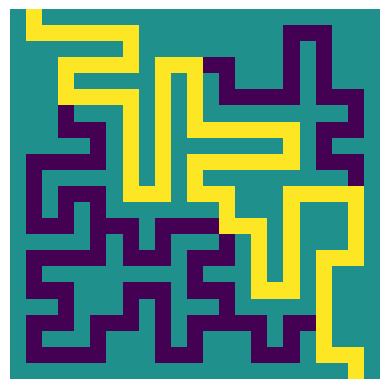

In [354]:
test_longest_path = compute_longest_path(test_input)

# Expect 94 steps in longest path
assert len(test_longest_path) - 1 == 94

_ = plot_path(test_input, test_longest_path)

This matches the expected longest path for this example maze. Now let's try again on the full sized maze -this maze is much larger, so it will take longer to consider all possible paths through the maze:

In [355]:
%timeit compute_longest_path(input_23)

13.5 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


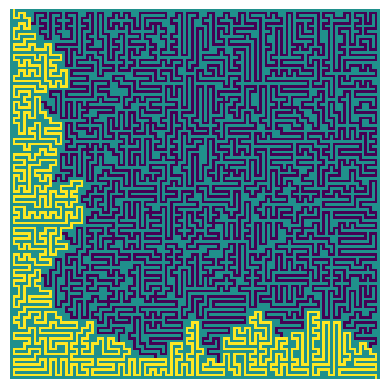

In [357]:
longest_path = compute_longest_path(input_23)
_ = plot_path(input_23, longest_path)

The longest path through this larger maze has been found, with the following number of steps:

In [360]:
len(longest_path) - 1

2202

And so the answer to part 1 is: __2202__.

## Part 2

In the second part of the puzzle, the directional tiles are now replaced with normal path tiles, so there is no longer any restriction on where we can walk. However, this dramatically increases the number of possible paths between the start and end of the maze, meaning that the implementation from part 1 is no longer feasible in a reasonable time.

A new approach is clearly required - the first insight is that we can represent all the useful information of the maze layout with a weighted graph with the following properties:
- The nodes represent places in the maze where the path forks into 2 or more other paths
- The edges represent connecting paths between these forks.

In order to construct this graph, we can use a similar DFS approach to earlier - this time keeping track of the fork tiles when they are found, and also recording the tiles in each segment connecting the fork tiles:

In [335]:
def compute_nodes(grid):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    # Track nodes (fork tiles), and
    # segments (paths between fork tiles)
    nodes = [(0, 1)]
    segments = {}
    paths = [[(0, 1), (1, 1)]]

    while paths:
        path = paths.pop()
        
        # For current path, find all
        # potential neighbours
        row, col = path[-1]
        possible_neighbours = [
            ((row-1, col), 'N'),
            ((row+1, col), 'S'),
            ((row, col-1), 'W'),
            ((row, col+1), 'E')
        ]

        # Work out if the new tile is a fork
        actual_neighbours = []
        for new_tile, direction in possible_neighbours:
            
            # Skip if not in grid
            if not 0 <= new_tile[0] < n_rows:
                continue
            if not 0 <= new_tile[1] < n_cols:
                continue
            
            # Skip if path is self-intersecting
            if new_tile in path:
                continue
            
            # Skip if new tile is a wall
            tile_type = grid[new_tile[0]][new_tile[1]]
            if tile_type == '#':
                continue

            actual_neighbours.append(new_tile)

        # 3 different cases for tile type
        n_neighbours = len(actual_neighbours)
        if n_neighbours == 0:
            # Reached end tile
            segments[(path[0], (row, col))] = path
            nodes.append((row, col))

        elif n_neighbours > 1:
            # Reached fork - add to nodes
            # if not already added
            if (row, col) not in nodes:
                for n in actual_neighbours:
                    # Add new paths to stack
                    paths.append([(row, col), n])
                nodes.append((row, col))

            # Make record of segment
            segments[(path[0], (row, col))] = path

        elif n_neighbours == 1:
            # Continue along path
            for n in actual_neighbours:
                paths.append([*path, n])

    return nodes, {tuple(sorted(k)): v for k, v in segments.items()}

Let's use this to find the weighted graph for the smaller example maze:

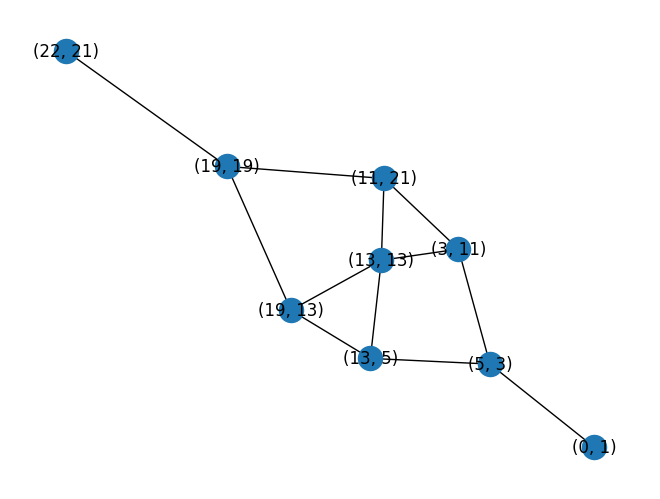

In [220]:
test_nodes, test_segments = compute_nodes(test_input)

# Visualize graph using networkx
test_graph = nx.Graph()
test_graph.add_weighted_edges_from([(segment[0], segment[1], len(path) - 1) for segment, path in test_segments.items()])
nx.draw(test_graph, with_labels=True, pos=nx.spring_layout(test_graph, iterations=200))

As we can see, the reduced graph is significantly smaller and more manageable than the full maze. The longest path-finding implementation from earlier can be reimplemented, to operate directly on the graph instead:

In [336]:
def compute_longest_graph_path(graph, start, end):
    # Create paths stack
    paths = [[start]]
    
    # Track longest path seen so far
    max_length = 0
    max_path = []

    while paths:
        path = paths.pop()
        
        if path[-1] == end:
            # Reached final node (end tile)
            # Find path length
            length = 0
            for n1, n2 in zip(path[:-1], path[1:]):
                length += graph.edges[(n1, n2)]['weight']
                
            # Save path if longest so far
            if length > max_length:
                max_length = length
                max_path = path
            
            # Skip to next path in stack
            continue
        
        # Find neighbours from graph adjacency matrix
        neighbours = list(graph.adj[path[-1]])
        
        for n in neighbours:
            if n not in path:
                # Add path if not self-intersecting
                paths.append([*path, n])
    
    return max_path, max_length

The plotting function also needs to be modified, in order to construct the full path (including all path tiles) back from the list of individual nodes along the obtained path. Recall that the nodes represent the fork tiles in the original maze, so the `segments` are used to find the tiles in each path connecting two fork tiles.

In [214]:
def plot_path_from_segments(grid, path_nodes, segments, **fig_kwargs):
    # Create a matrix with 1s along the path
    # and 0s everywhere else
    n_rows = len(grid)
    n_cols = len(grid[0])
    p = np.zeros([n_rows, n_cols])
    
    # Loop over nodes in longest path
    for node_1, node_2 in pairwise(path_nodes): 
        
        # Find tiles along segment
        # connecting these nodes
        key = tuple(sorted((node_1, node_2)))
        for row, col in segments[key]:
            p[row, col] = 1

    # Plot the optimal path over the top of a heat map
    # showing the costs of each tile
    fig, ax = plt.subplots(**fig_kwargs)
    ax.matshow(np.maximum(2*p, [[grid[i][j]=='#'
                        for j in range(n_cols)] 
                        for i in range(n_rows)
                    ]))
    ax.axis('off')
    return fig, ax

For the example maze, this allows us to find the path through the reduced graph with the maximum length, and visualize it on the original maze:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

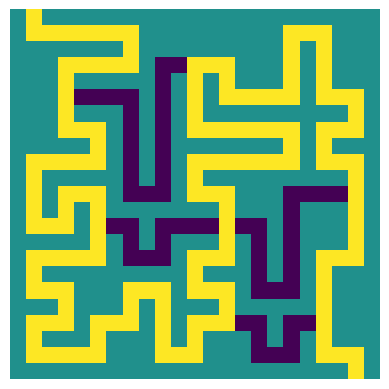

In [338]:
test_path_nodes, test_max_length = compute_longest_graph_path(test_graph, (0, 1), (22, 21))
plot_path_from_segments(test_input, test_path_nodes, test_segments)

Moving on to the full maze now, let's take a look at the reduced graph obtained from the fork tiles found in the maze:

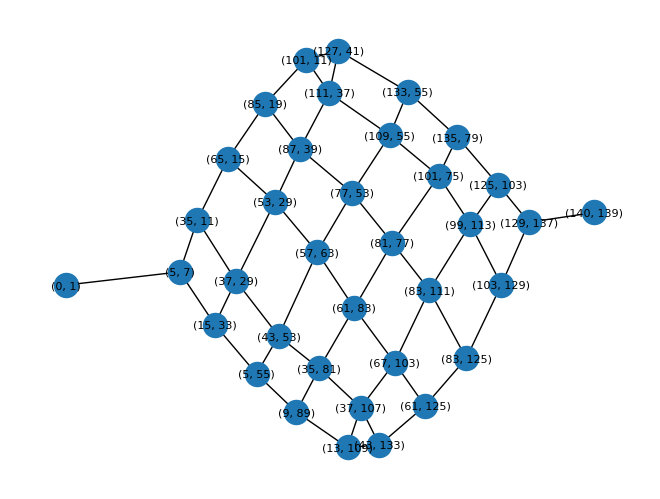

In [246]:
nodes, segments = compute_nodes(input_23)

# Visualize graph using networkx
graph = nx.Graph()
graph.add_weighted_edges_from([(segment[0], segment[1], len(path) - 1) for segment, path in segments.items()])
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, iterations=200), font_size=8)

Again, a significant improvement from the original maze! Plugging this graph into the `compute_graph_path` function, in its current form, takes about 1min 30s of CPU time to find the longest path:

In [334]:
%time path_nodes, max_length = compute_longest_graph_path(graph, (0, 1), (140, 139))

CPU times: total: 1min 36s
Wall time: 2min 6s


We can visualize the path through the graph which maximises the total length:

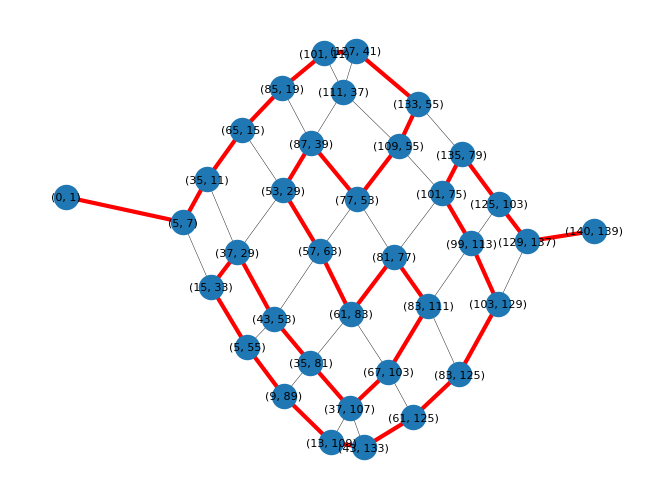

In [406]:
# Identify edges along maximal length path
colors = []
widths = []
path_edges = [tuple(sorted(edge)) for edge in list(pairwise(path_nodes))]
for edge in graph.edges:
    edge = tuple(sorted(edge))
    if edge in path_edges:
        colors.append('red')
        widths.append(3)
    else:
        colors.append('black')
        widths.append(0.3)

# Draw longest path on graph
nx.draw(graph, 
        with_labels=True, 
        pos=nx.spring_layout(graph, iterations=200), 
        edge_color=colors, 
        font_size=8,
        width=widths)

The maximal length path (defined by the sequence of nodes in the graph) can now be converted back into the full path through the original maze:

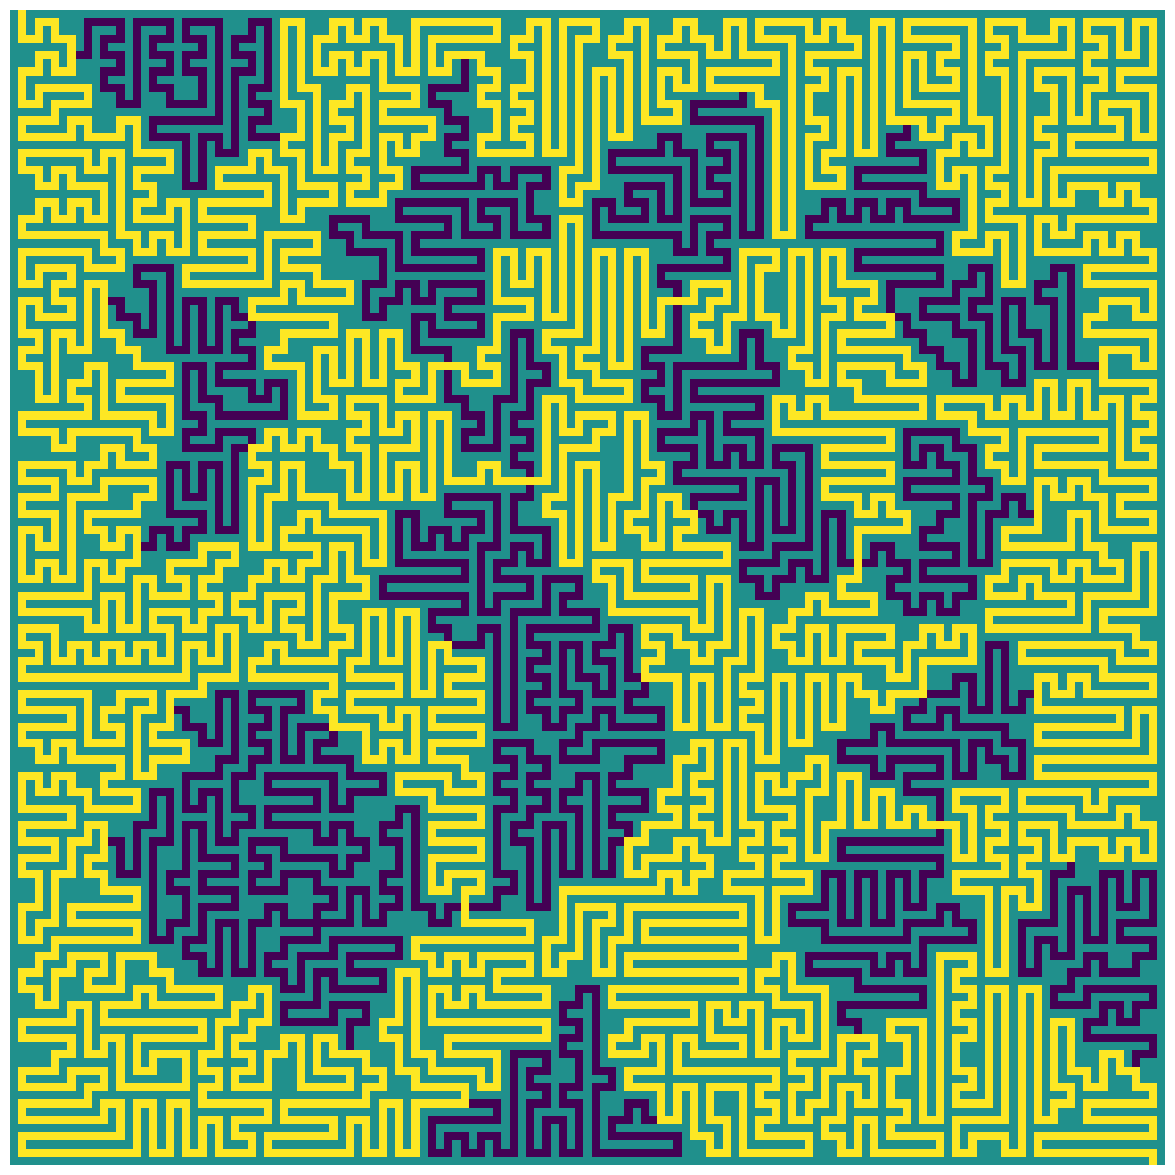

In [340]:
_ = plot_path_from_segments(input_23, path_nodes, segments, figsize=(15, 15))

The number of steps taken in the path with the maximum length is:

In [342]:
max_length

6226

And so the answer to part 2 is: __6226__.
    
There are further optimizations that can be done, in order to improve the running time of the function `compute_graph_path`. Firstly, it is not necessary to use a `networkx.Graph` object to represent the graph, as we do not require all of the available functionality - only the node adjacencies and the weighted graph edges. Therefore, by storing these as python `dict` objects at the start of the function, we can avoid large numbers of queries to the `networkx.Graph`.

Secondly, instead of storing the current path as a list of graph nodes, it is more efficient to represent it as a `dict`. When checking the path for self-intersection, we are currently looping over all nodes in the current path list, whereas using a `dict` means that this check is independent of the length of the current path. For Python versions 3.6 and up, the keys of a `dict` are kept in the order in which they are inserted (this was originally an accident of the implementation, but later became a guaranteed feature); therefore, the order of the nodes in the path can be effectively represented as keys in a `dict`.

Finally (credit to [this Reddit post](https://www.reddit.com/r/adventofcode/comments/18oy4pc/comment/kfyvp2g/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button) for the insight), it is possible to reduce the number of paths during the DFS by observing that the nodes around the perimeter of the reduced graph have a special property. Paths which travel between nodes on the perimeter must only do so in one direction (towards the end node) - it straighforward to see from inspection that any path which reaches a perimeter node and then moves in the other direction becomes 'trapped' due to the non-self-intersecting property of the path. We can enumerate all of the edges between perimeter nodes, reading them directly off the graph visualization:

In [283]:
perimeter_segments = set([
    ((0, 1), (5, 7)),
    ((5, 7), (35, 11)),
    ((35, 11), (65, 15)),
    ((65, 15), (85, 19)),
    ((85, 19), (101, 11)),
    ((101, 11), (127, 41)),
    ((127, 41), (133, 55)),
    ((133, 55), (135, 70)),
    ((135, 70), (125, 103)),
    ((125, 103), (129, 137)),
    ((129, 137), (140, 139)),
    ((5, 7), (15, 33)),
    ((15, 33), (5, 55)),
    ((5, 55), (9, 89)),
    ((9, 89), (13, 109)),
    ((13, 109), (43, 133)),
    ((43, 133), (61, 125)),
    ((61, 125), (83, 125)),
    ((83, 125), (103, 129)),
    ((103, 129), (129, 127))
])

During the DFS, if we ever encounter a perimeter node, we can only consider paths which move in the correct direction around the perimeter, and discard the other path going in the opposite direction.

Combining these optimizations into an improved implementation of the path-finding function:

In [331]:
def compute_longest_graph_path_with_perimeter(graph, start, end, perimeter_segments):
    # Stack of paths, represented as dicts
    paths = [{start: None}]
    
    # Track longest path seen so far
    max_length = 0
    max_path = []
    
    # Graph adjacency and edge information
    weights = {tuple(sorted(edge)): weight['weight'] 
               for edge, weight in graph.edges.items()}
    adj = {node: list(nodes.keys()) 
           for node, nodes in graph.adj.items()}

    while paths:
        path = paths.pop()
        path_keys = list(path.keys())
        
        if path_keys[-1] == end:
            # Reached final node (end tile)
            # Find path length
            length = 0
            for n1, n2 in zip(path_keys[:-1], path_keys[1:]):
                length += weights[tuple(sorted((n1, n2)))]
                
            # Save path if longest so far
            if length > max_length:
                max_length = length
                max_path = path_keys
                
            # Skip to next path in stack
            continue
        
        # Find neighbours from graph adjacency dict
        neighbours = adj[path_keys[-1]]
        
        for n in neighbours:
            # Add path if not self-intersecting
            # and not in wrong direction around perimeter
            if (n not in path) and ((n, path_keys[-1]) not in perimeter_segments):
                paths.append({**path, n: None})
    
    return max_path, max_length

Testing this new implementation with the same inputs as before:

In [332]:
%time path_nodes, max_length = compute_longest_graph_path_with_perimeter(graph, (0, 1), (140, 139), perimeter_segments)

CPU times: total: 27 s
Wall time: 36 s


This has reduced the runtime down to about 30s of CPU time, which is good enough for me. For general mazes containing cycles, the problem is known to be NP-hard (see [here](https://en.wikipedia.org/wiki/Longest_path_problem)), so further optimizations would most likely involve improvements to the data structures used, or additional heuristics to reduce the number of paths considered, rather than drastically different algorithmic approaches.